### Домашняя работа "Decision trees"

In [1]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

In [2]:
data = pd.read_csv(load_boston()['filename'], skiprows=1)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
df = data.copy()

Содержит информацию о жилье в Бостоне, собранную бюро переписи населения США.

- CRIM - уровень преступности на душу населения
- ZN - доля земли под жилую застройку,
- INDUS - доля акров, не относящихся к розничной торговле.
- CHAS - фиктивная переменная реки Чарльз (1, если участок ограничивает реку; 0 в противном случае)
- NOX - концентрация оксидов азота 
- RM - среднее количество комнат в доме
- AGE - доля занимаемых владельцами единиц, построенных до 1940 г.
- DIS - взвешенное расстояние до пяти бостонских центров занятости
- RAD - индекс доступности радиальных автомобильных дорог
- TAX - полная ставка налога на имущество за 10 000 долларов США.
- PTRATIO - соотношение учеников и учителей по городам
- B - 1000 (Bk - 0,63) ^ 2, где Bk - доля афроамериканцев по городам
- LSTAT - % более населения низкого соц статуса
- MEDV - Средняя стоимость домов в 1000 долларов

Отсутствуют пропущенные значения

In [4]:
data.describe().round(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,0.01,0.00,0.46,0.00,0.38,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.22,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


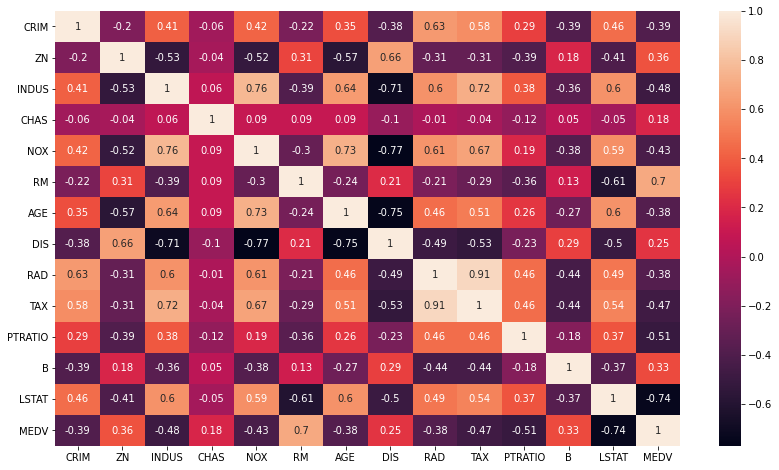

In [5]:
rcParams['figure.figsize'] = 14,8

correlation_matrix = data.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True);

Посмотрев на матрицу корреляции, мы можем увидеть, что RM имеет сильную положительную корреляцию с MEDV (0,7), тогда как LSTAT имеет высокую отрицательную корреляцию с MEDV (-0,74) 

Важным моментом при выборе признаков для модели линейной регрессии является проверка на мультиколинейность. Характеристики RAD , TAX имеют соотношение 0,91 . Эти пары функций сильно коррелированы друг с другом. Это может повлиять на модель. То же самое касается функций DIS и AGE, у которых соотношение составляет -0,75 .

Распределение цен на жилье по LTSTAT и RM


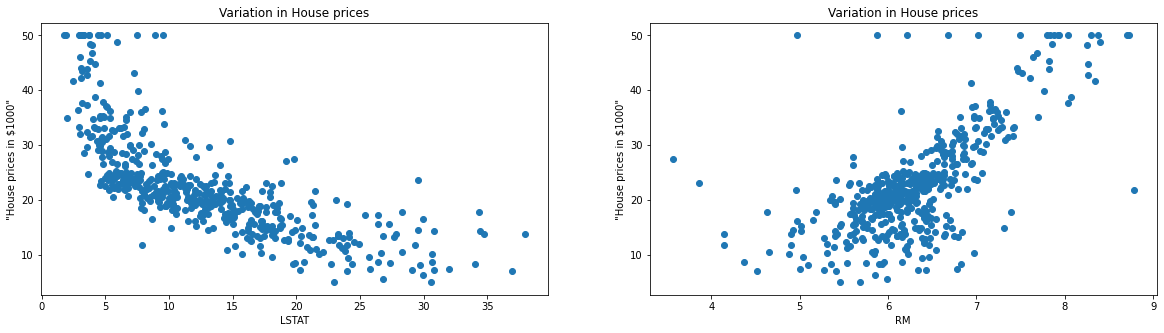

In [6]:
plt.figure(figsize=(20, 5))

print('{}'.format('Распределение цен на жилье по LTSTAT и RM'))

feature_cols = ['LSTAT', 'RM']
target = ['MEDV']

for i, col in enumerate(feature_cols):
    plt.subplot(1, len(feature_cols) , i+1)
    x = df[col]
    y = df[target]
    plt.scatter(x, y, marker='o')
    plt.title("Variation in House prices")
    plt.xlabel(col)
    plt.ylabel('"House prices in $1000"')


#### Проверим данные на выбросы

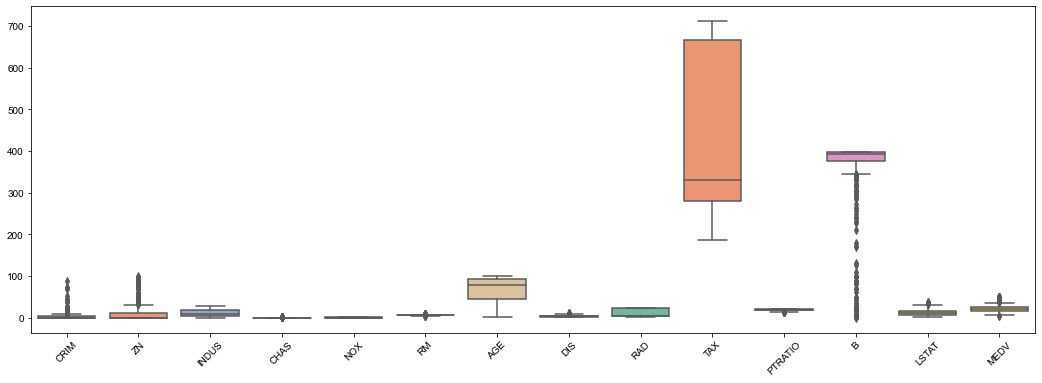

In [7]:
rcParams['figure.figsize'] = 18,6

plt.xticks(rotation=45)
sns.set_theme(style="darkgrid")

sns.boxplot(data = df, palette="Set2", orient = 'v');

In [8]:
def outliers(data):
    q25, q75 =data.quantile([.25, .75])
    iqr = q75-q25
    return data.between(q25-1.5*iqr, q75+1.5*iqr)

In [9]:
outlier_threshold  = 0.1
to_exclude_outlier_cols = []
print('{:<8}  {}'.format('Признак', 'Выброс'))
for col in df.drop('MEDV', 1).columns:
    outlier_share = 1- outliers(df[col]).mean()    
    print('{:<8}  - {:.2%}'.format(col, outlier_share))
    if outlier_share < outlier_threshold:
        to_exclude_outlier_cols.append(col)

Признак   Выброс
CRIM      - 13.04%
ZN        - 13.44%
INDUS     - 0.00%
CHAS      - 6.92%
NOX       - 0.00%
RM        - 5.93%
AGE       - 0.00%
DIS       - 0.99%
RAD       - 0.00%
TAX       - 0.00%
PTRATIO   - 2.96%
B         - 15.22%
LSTAT     - 1.38%


#### Удалим выбросы

In [10]:
df = df[df[to_exclude_outlier_cols].fillna(0).apply(outliers).all(1)]

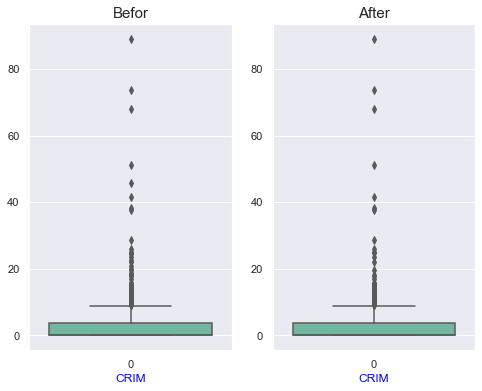

In [11]:
rcParams['figure.figsize'] = 8,6

plt.subplot(1, 2, 1)
plt.title('Befor', fontsize=15)
sns.boxplot(data = data['CRIM'], palette="Set2", orient = 'v');
plt.xlabel('CRIM', fontsize=12, color='blue');

plt.subplot(1, 2, 2)
plt.title('After', fontsize=15)
sns.boxplot(data = df['CRIM'], palette="Set2", orient = 'v');
plt.xlabel('CRIM', fontsize=12, color='blue');

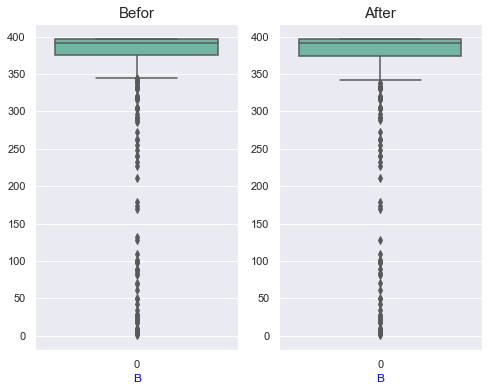

In [12]:
rcParams['figure.figsize'] = 8,6

plt.subplot(1, 2, 1)
plt.title('Befor', fontsize=15)
sns.boxplot(data = data['B'], palette="Set2", orient = 'v');
plt.xlabel('B', fontsize=12, color='blue');

plt.subplot(1, 2, 2)
plt.title('After', fontsize=15)
sns.boxplot(data = df['B'], palette="Set2", orient = 'v');
plt.xlabel('B', fontsize=12, color='blue');

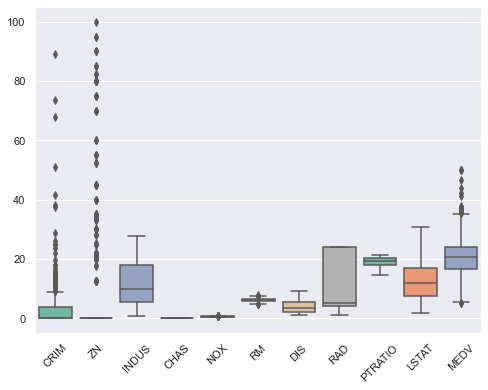

In [13]:
plt.xticks(rotation=45)
rcParams['figure.figsize'] = 20,6
sns.set_theme(style="darkgrid")
sns.boxplot(data = df.drop(['TAX', 'B', 'AGE'],1), palette="Set2", orient = 'v');

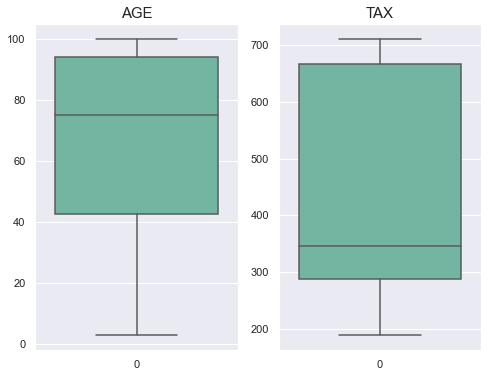

In [14]:
rcParams['figure.figsize'] = 8,6

plt.subplot(1, 2, 1)
plt.title('AGE', fontsize=15)
sns.boxplot(data = df['AGE'], palette="Set2", orient = 'v');

plt.subplot(1, 2, 2)
plt.title('TAX', fontsize=15)
sns.boxplot(data = df['TAX'], palette="Set2", orient = 'v');

### Цены на недвижимость которые нужно предсказать

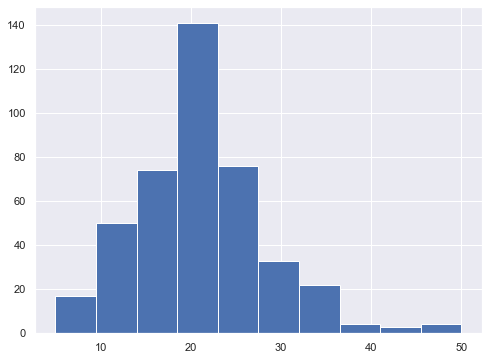

In [15]:
df['MEDV'].hist();

In [16]:
# df['MEDV'] = df['MEDV'].apply(lambda x: int(x))

Сделаем погноз для:   
features = ['LSTAT', 'RM']  
target = df['MEDV']

### Отбор признаков

In [17]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(random_state = 0,
                               max_depth=3, min_samples_leaf=5)

Х_feature = df.drop('MEDV', 1)
Y_feature = df[target]


# Выполним стандартизацию признаков
sc = StandardScaler()

sc.fit(Х_feature)
# Тренировочные значения 
Х_feature_std = sc.transform(Х_feature)

# Обучим для отбора признаков
clf.fit(Х_feature_std, Y_feature)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, random_state=0)

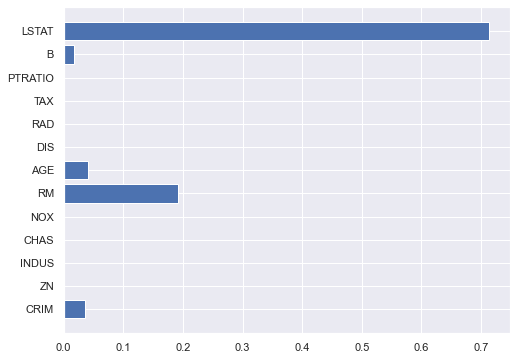

In [18]:
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(df.columns[:-1])),df[df.columns[:-1]]);

### Обучем модель на отобранных признаках

In [19]:
feature_cols = ['LSTAT', 'RM']

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], df['MEDV'], test_size=0.3, random_state=0)

# Выполним стандартизацию признаков

sc = StandardScaler()

sc.fit(X_train)
# Тренировочные значения 
X_train_std = sc.transform(X_train)
# Тестовые значения
X_test_std = sc.transform(X_test)

**Гиперпараметры алгоритма**

Параметры деревьев
1. criterion - критерий построения дерева
2. max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)


In [77]:
# DecisionTreeRegressor
# from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(criterion = "mse", 
                            random_state = 50,
                            max_depth=6,
                            min_samples_leaf=10, 
                            min_samples_split = 4, 
                            max_features='log2')

clf.fit(X_train_std, y_train)
preds = clf.predict(X_test_std)

### Сoefficient of determination R2

In [79]:
r2 = round(clf.score(X_test_std, y_test),4)

print("R^2: {}".format(r2))

R^2: 0.7324


### Визуализация

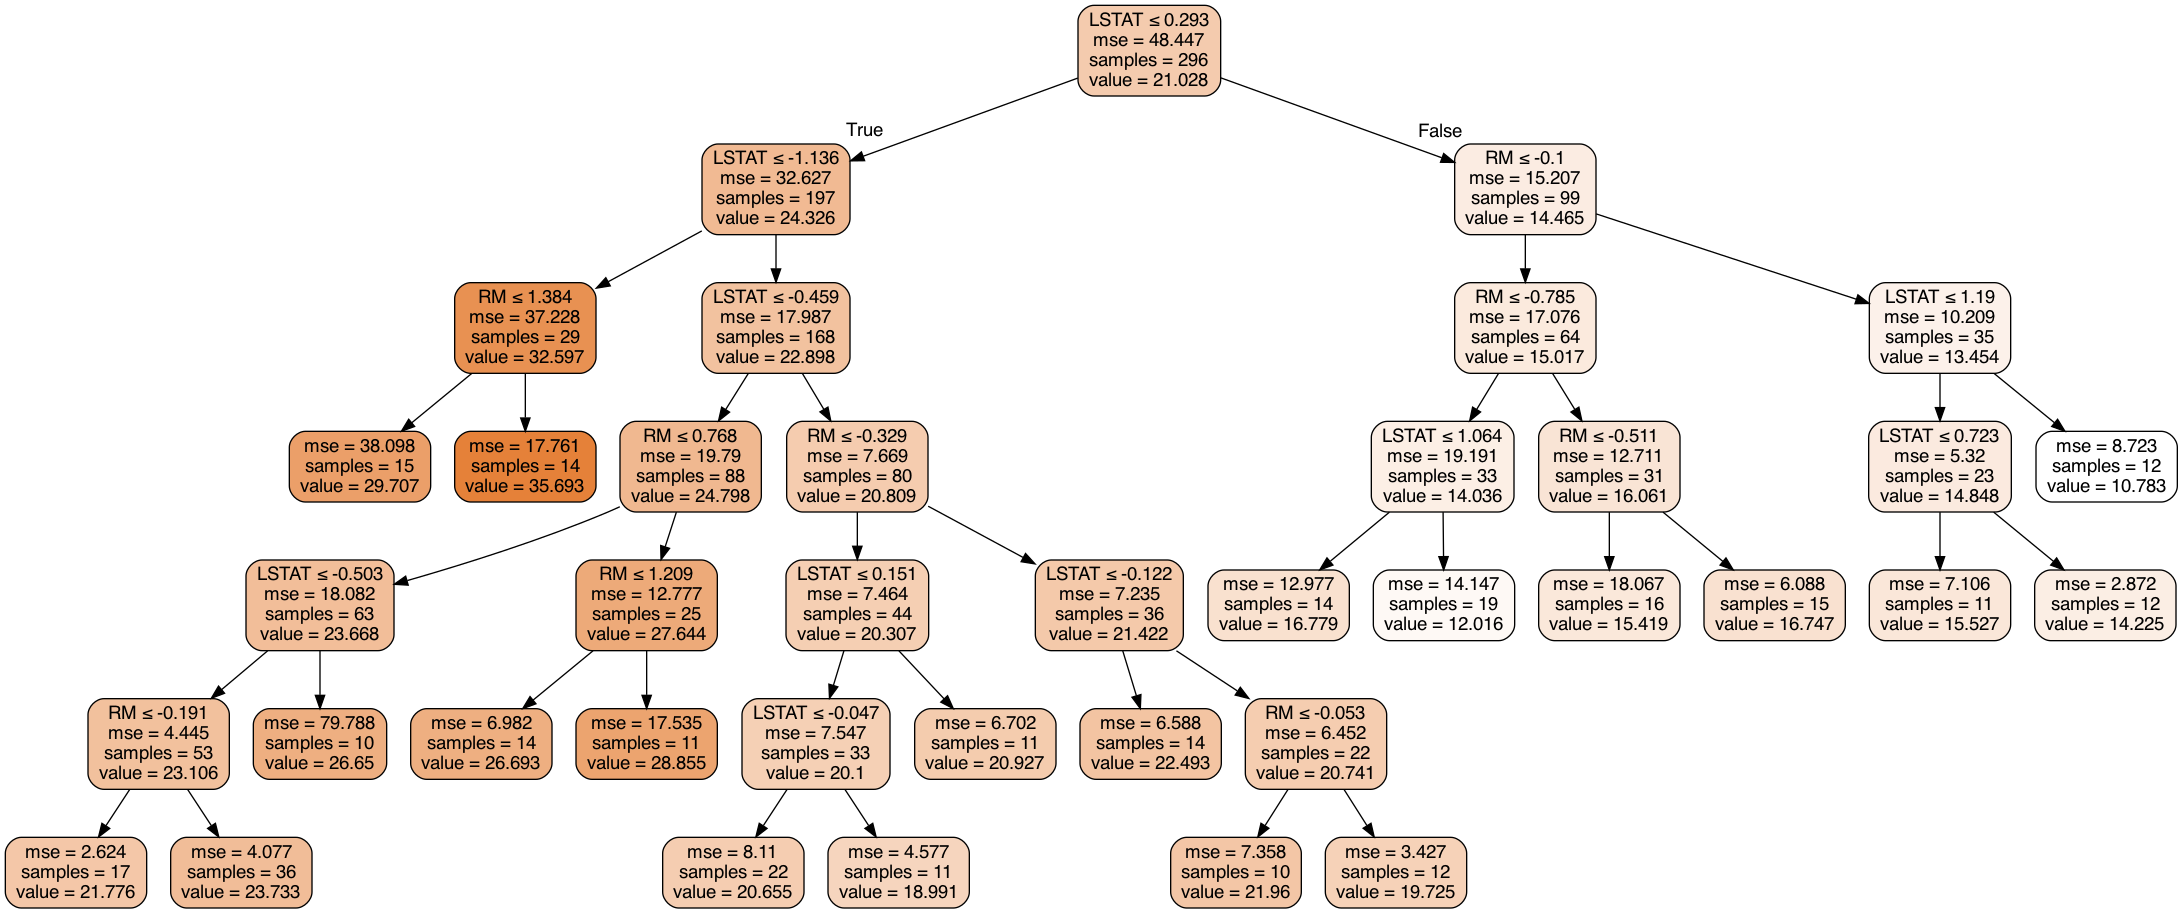

In [80]:
#visualizing the tree
import io
from io import StringIO
from sklearn.tree import export_graphviz

# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
# import graphviz

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols)
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())